In [1]:
using ColorBrewer
using Dates
using DecisionTree
using Distributions
using DataFrames
using LaTeXStrings
using Measures
using Plots
using Statistics

gr()
default(fontfamily="Times")

[ Info: Precompiling ColorBrewer [a2cac450-b92f-5266-8821-25eda20663c8] (cache misses: incompatible header (2))
[ Info: Precompiling StyledStringsExt [e8f1f8a7-7f11-520c-bb0f-13aae97f28ab] (cache misses: incompatible header (2))
[ Info: Precompiling DecisionTree [7806a523-6efd-50cb-b5f6-3fa6f1930dbb] (cache misses: incompatible header (2))
[ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] (cache misses: incompatible header (2))
[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] (cache misses: incompatible header (2))
[ Info: Precompiling ParsersExt [f526588d-e68b-5dc5-a62e-ff9f36e48b1a] (cache misses: incompatible header (2))
[ Info: Precompiling Measures [442fdcdd-2543-5da2-b0f3-8c86c306513e] (cache misses: incompatible header (2))
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: incompatible header (2))
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b] (cache misses: incompatible

# Data Generating Process

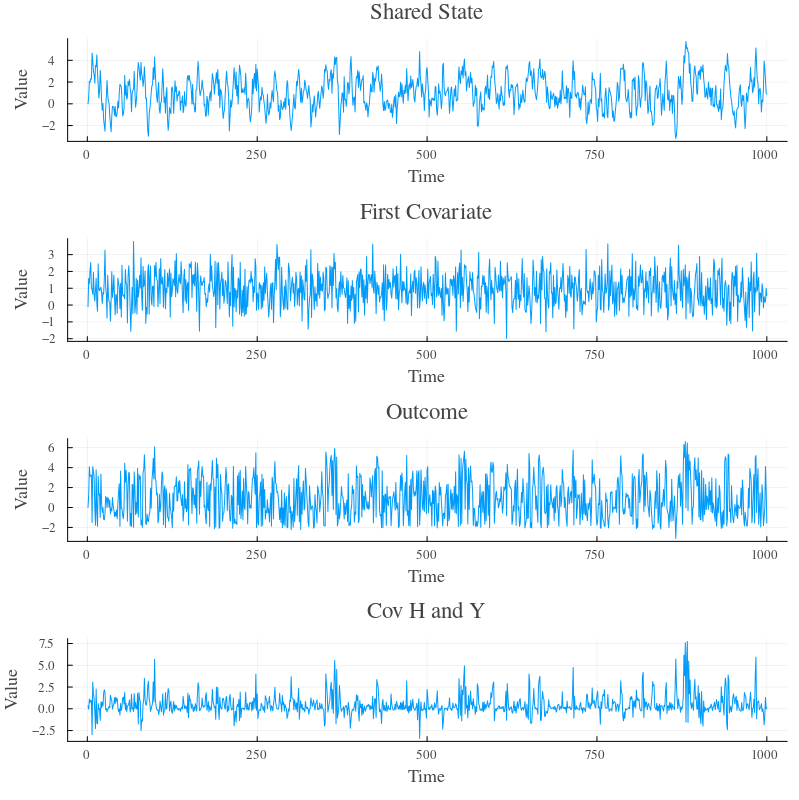

In [2]:
function sigmoid(x)
    return 1 / (1 + exp(-x))
end

function h_star_sb(D_prev, X_prev, H_prev)
    """ 
    Compute the shared state given the previous state observations
    """
    dim = size(X_prev, 1) + 1
    H_new = reduce(vcat, [D_prev, X_prev, H_prev[1:size(H_prev, 1)-dim]])
    return H_new
end

function h_star_ade(D_prev, X_prev, Y_prev, H_prev)
    """
    Compute the shared state given the previous state observations
    """
    rho = 0.75
    sigma = 1

    mu = 1
    H_new = mu + rho * (H_prev[1] - mu) + randn()*sigma
    return H_new
end


function h_star_global(D, X, H, treatment_assignment, est_ade)
    """
    Compute the shared state under global treatment or control
    """
    T = length(D)
    d_H = size(H, 2)
    H_global = zeros(T, d_H)
    H_global[1,:] = randn(d_H) # random initial state
    for t in 2:T
        if est_ade
            H_global[t,:] = h_star_ade(treatment_assignment, X[t-1,:], Y[t-1], H_global[t-1,:]) 
        else
            H_global[t,:] = h_star_sb(treatment_assignment, X[t-1,:], H_global[t-1,:])
        end
    end
    return H_global
end

function f_star(D, X, H, alpha, est_ade; beta = 0.5)
    """ 
    Compute the outcome at time t given covariates and the shared state
    """
    T = length(D)
    x_effect = sin(X[1]*2*pi)
    d_effect = 2*D - 1  
    if est_ade
        h_effect = H[1] 
        return x_effect + d_effect + alpha * h_effect * D
    else
        rng = collect(1:6:size(H, 1))
        h_effect = exp.(-H[rng] / 3)
        h_effect = 2 * sigmoid(sum(h_effect)) - 1 
        return 2 * beta * x_effect + d_effect + 2 * (1 - beta) * alpha * h_effect
    end
end


function dgp(T, m, n_covariates, switch_period; mode="switch", est_ade = true, alpha = 1, sd_error = 1, eps = 0.1, beta = 0.5)
      
    sigma = 1
    if est_ade
        X = (randn(T, n_covariates) .+ 1) .* sigma
    else
        X = rand(T, n_covariates)
    end
    
    if mode == "switch"
        D = zeros(Int, T)
        first_switch = rand(1:switch_period)
        D[1:first_switch-1] .= rand() < 0.5
        for i in 1:ceil(Int, T/switch_period)
            start_idx = (i-1)*switch_period + first_switch
            end_idx = min(i*switch_period + first_switch - 1, T) 
            D[start_idx:end_idx] .= rand() < 0.5 
        end
    elseif mode == "global treatment"
        D = ones(Int, T)
    elseif mode == "global control"
        D = zeros(Int, T)
    elseif mode == "observational"
        D = [rand() < max(min(X[t,1], 1-eps), eps) ? 1 : 0 for t in 1:T]
    end 
    @assert !isnothing(D) "D must be defined"
    
    Y = zeros(T)
    if est_ade
        d_H = 1
    else
        d_H = (size(X, 2) + 1)*m
    end
    H = zeros(T, d_H)
    for t in 2:T
        if est_ade
            H[t,1] = h_star_ade(D[t-1], X[t-1,:], Y[t-1], H[t-1,:]) 
        else
            H[t,:] = h_star_sb(D[t-1], X[t-1,:], H[t-1,:])
        end
        Y[t] = f_star(D[t], X[t,:], H[t,:], alpha, est_ade; beta = beta) + randn()/sd_error
    end
    
    return D, X, H, Y
end

function create_features(X, D, H)
    return reduce(hcat, [X, D, H])
end

T = 1000  # Number of time periods
m = 50    # m-dependence parameter
switch_period = 100  # Period between treatment switches
n_samples = 3
sd_error = 10
alpha_val = 1
eps = 0.05

D, X, H, Y = dgp(T, m, 1, switch_period, mode = "observational", est_ade = true, alpha = alpha_val, sd_error = sd_error, eps = eps, beta = 0.5)

p1 = plot(1:T, [H[t,1] for t in 1:T], title="Shared State", xlabel="Time", ylabel="Value")
p2 = plot(1:T, X[:,1], title="First Covariate", xlabel="Time", ylabel="Value") 
p3 = plot(1:T, Y, title="Outcome", xlabel="Time", ylabel="Value")
p4 = plot(1:T, [(H[t,1] - mean(H[:,1])) * (Y[t] - mean(Y))/std(Y)/std(H[:,1]) for t in 1:T], xlabel="Time", ylabel="Value", title="Cov H and Y")
plot(p1, p2, p3, p4, layout=(4,1), size=(800,800), legend=false)


# Calculate metrics

In [3]:
function calculate_metrics(y_true, y_pred)
    # Calculate RMSE
    rmse = sqrt(mean((y_true .- y_pred).^2))
    
    # Calculate R²
    ss_res = sum((y_true .- y_pred).^2)
    ss_tot = sum((y_true .- mean(y_true)).^2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Print 
    println("RMSE: ", round(rmse, digits=4))
    println("R²: ", round(r2, digits=4))
    
    return rmse, r2
end


function generate_models(T, m, n_covariates, switch_period; mode, est_ade, alpha, sd_error, n_trees, max_depth, eps, beta = 0.5)
    D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha, sd_error=sd_error, eps=eps, beta = beta)

    W = create_features(X, D, H)

    outcome_model = RandomForestRegressor(n_trees=n_trees, max_depth=max_depth)
    fit!(outcome_model, W, Y)

    propensity_model = RandomForestRegressor()
    fit!(propensity_model, X, D)

    return outcome_model, propensity_model
end

function generate_naive_models(T, m, n_covariates, switch_period; mode, est_ade, alpha, sd_error, n_trees, max_depth, eps, beta = 0.5)
    D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps, beta = beta)
    W = reduce(hcat, [X, D])

    outcome_model = RandomForestRegressor(n_trees=n_trees, max_depth=max_depth)
    fit!(outcome_model, W, Y)

    propensity_model = RandomForestRegressor(n_trees=n_trees, max_depth=max_depth)
    fit!(propensity_model, X, D)

    return outcome_model, propensity_model
end


function evaluate_models(outcome_model, propensity_model; mode, est_ade, alpha, sd_error, eps)
    D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps)
    X_test = create_features(X, D, H)
    y_pred = predict(outcome_model, X_test)
    println("Outcome model -- Out of sample:")
    calculate_metrics(Y, y_pred)

    propensity_pred = predict(propensity_model, X)
    println("Propensity model -- Out of sample:")
    calculate_metrics(D, propensity_pred)
    return propensity_pred
end

# T = 10000  # Number of time periods
# m = 5    # Temporal dependence 
# n_covariates = 10
# switch_period = 10    
# alpha_val = 1
# sd_error = 1
# n_trees = 100
# max_depth = 10

# mode = "observational"
# est_ade = true
# println("Evaluating correctly specified model")
# outcome_model, propensity_model = generate_models(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)
# evaluate_models(outcome_model, propensity_model; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps);

# println("Evaluating naive model")
# naive_outcome_model, naive_propensity_model = generate_naive_models(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)
# evaluate_models(naive_outcome_model, naive_propensity_model; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps);




evaluate_models (generic function with 1 method)

# Estimators

In [4]:
function naive_dml_phi(D, X, Y, naive_outcome_model, propensity_model, eps)
    T = length(D)
    W_observed = reduce(hcat, [X, D])
    W_observed_treat = copy(W_observed)
    W_observed_ctrl = copy(W_observed)
    Y_pred = predict(naive_outcome_model, W_observed)
    propensity_pred = predict(propensity_model, X)
    propensity_pred = clamp.(propensity_pred, eps, 1-eps)
    residuals = Y .- Y_pred
    curr_d_ind = size(X, 2) + 1
    W_observed_treat[:,curr_d_ind] .= 1
    W_observed_ctrl[:,curr_d_ind] .= 0
    plugin_estimator = predict(naive_outcome_model, W_observed_treat) .- predict(naive_outcome_model, W_observed_ctrl)

    debiasing_term = [D[t]/propensity_pred[t] - (1-D[t])/(1-propensity_pred[t]) for t in 1:T] .* residuals

    return plugin_estimator .+ debiasing_term, plugin_estimator
end

function naive_dml(D, X, Y, naive_outcome_model, propensity_model, eps)
    return mean(naive_dml_phi(D, X, Y, naive_outcome_model, propensity_model, eps)[1])
end

# mode = "observational"
# est_ade = true
# eps = 0.05
# naive_outcome_model, naive_propensity_model = generate_naive_models(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)

# D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps)
# naive_dml_estimates, naive_plugin_estimates = naive_dml(D, X, Y, naive_outcome_model, naive_propensity_model, eps)
# naive_dml_est = mean(naive_dml_estimates)
# naive_plugin_est = mean(naive_plugin_estimates)
# println("\nNaive DML direct effect estimate: ", round(naive_dml_est, digits=4))
# println("\nNaive plugin direct effect estimate: ", round(naive_plugin_est, digits=4))


naive_dml (generic function with 1 method)

In [ ]:
function dml4ssi_phi_ade(D, X, H, Y, outcome_model, propensity_model, eps)
    T = length(D)
    # Calculate residuals
    W_observed = create_features(X, D, H)
    curr_d_ind = size(X, 2) + 1
    Y_pred = predict(outcome_model, W_observed)
    propensity_pred = predict(propensity_model, X)
    propensity_pred = clamp.(propensity_pred, eps, 1-eps)

    W_observed_treat = copy(W_observed)
    W_observed_ctrl = copy(W_observed)
    W_observed_treat[:,curr_d_ind] .= 1
    W_observed_ctrl[:,curr_d_ind] .= 0
    plugin_estimator = predict(outcome_model, W_observed_treat) .- predict(outcome_model, W_observed_ctrl)

    residuals = Y .- Y_pred
    @assert sum(propensity_pred .<= 0 .|| propensity_pred .>= 1 ) == 0 "Propensity scores must be between 0 and 1"
    debiasing_term = [D[t]/propensity_pred[t] - (1-D[t])/(1-propensity_pred[t]) for t in 1:T] .* residuals

    treatment_effects = plugin_estimator .+ debiasing_term

    return treatment_effects, plugin_estimator

end

function dml4ssi_ade(D, X, H, Y, outcome_model, propensity_model, eps)
    return mean(dml4ssi_phi_ade(D, X, H, Y, outcome_model, propensity_model, eps))
end

# eps = 0.05
# mode = "observational"
# est_ade = true
# outcome_model, propensity_model = generate_models(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)
# evaluate_models(outcome_model, propensity_model; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps)

# D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps)
# ade_est_phi, plugin_ade_estimates_phi = dml4ssi_phi_ade(D, X, H, Y, outcome_model, propensity_model, eps)
# ade_est = mean(ade_est_phi)
# plugin_ade_estimates = mean(plugin_ade_estimates_phi)
# println("\nDML4SSI direct effect estimate: ", round(ade_est, digits=4))
# println("\nPlugin direct effect estimate: ", round(plugin_ade_estimates, digits=4))




dml4ssi_ade (generic function with 1 method)

In [6]:

# D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps)
# ade_est_phi, plugin_ade_estimates_phi = dml4ssi_phi_ade(D, X, H, Y, outcome_model, propensity_model, eps)
# ade_est = mean(ade_est_phi)
# plugin_ade_estimates = mean(plugin_ade_estimates_phi)
# println("\nDML4SSI direct effect estimate: ", round(ade_est, digits=4))
# println("\nPlugin direct effect estimate: ", round(plugin_ade_estimates, digits=4))

# naive_outcome_model, naive_propensity_model = generate_naive_models(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)
# naive_dml_estimates, naive_plugin_estimates = naive_dml(D, X, Y, naive_outcome_model, naive_propensity_model, eps)
# naive_dml_est = mean(naive_dml_estimates)
# naive_plugin_est = mean(naive_plugin_estimates)
# println("\nNaive DML direct effect estimate: ", round(naive_dml_est, digits=4))
# println("\nNaive plugin direct effect estimate: ", round(naive_plugin_est, digits=4))

In [ ]:
function switchback_ht(D, Y, k)
    """
    Calculate Horwitz-Thomson style estimator in switchback experiment
    """
    treatment_sum = 0.0
    control_sum = 0.0
    n_treatment = 0
    n_control = 0
    switches = diff(D) .!= 0
    switch_indices = findall(switches)

    # Create mask for observations to keep (false for m periods after each switch)
    valid_obs = trues(length(D))
    for switch_idx in switch_indices
        start_idx = switch_idx + 1
        end_idx = min(start_idx + k - 1, length(D))
        valid_obs[start_idx:end_idx] .= false
    end

    for i in 1:length(D)
        if valid_obs[i]
            if D[i] == 1
                treatment_sum += Y[i]
                n_treatment += 1
            else
                control_sum += Y[i]
                n_control += 1
            end
        end
    end

    treatment_effect = (treatment_sum / n_treatment) - (control_sum / n_control)
    return treatment_effect, valid_obs
end

# n_covariates = 1
# eps = 0.05
# D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode = "switch", est_ade = false, alpha = alpha_val, sd_error = sd_error, eps=eps)
# k = 5
# treatment_effect, valid_obs = switchback_ht(D, Y, k)
# println("\nSwitchback treatment effect estimate: ", round(treatment_effect, digits=4))



switchback_ht (generic function with 1 method)

In [ ]:
function dml4ssi_phi_switchback(D, X, H, Y, predictor, m, switch_period)
    """
    Calculate DML4SSI phi estimator in switchback experiment
    """
    T = length(D)

    # Calculate predicted values under all treatment and all control
    H_all_treat = h_star_global(D, X, H, 1, false)
    H_all_control = h_star_global(D, X, H, 0, false)
    
    W_all_treat = create_features(X, ones(length(D)), H_all_treat)
    W_all_control = create_features(X, zeros(length(D)), H_all_control)
    
    Y_pred_treat = predict(predictor, W_all_treat)
    Y_pred_control = predict(predictor, W_all_control)
    
    plugin_estimator = Y_pred_treat - Y_pred_control
    
    W_observed = create_features(X, D, H)
    Y_pred =  predict(predictor, W_observed)
    residuals = Y - Y_pred
    
    last_m_treatment = [all(D[max(t-m+1, 1):t] .== 1) for t in 1:T]
    last_m_control = [all(D[max(t-m+1, 1):t] .== 0) for t in 1:T]
    
    prob_m_ones = 1/2 - (m-1)/(4*switch_period)
    prob_m_zeros = 1/2 - (m-1)/(4*switch_period)
    debiasing_term = (last_m_treatment ./ prob_m_ones .- last_m_control ./ prob_m_zeros) .* residuals
    
    treatment_effects = plugin_estimator .+ debiasing_term
    
    return treatment_effects, plugin_estimator
end

function dml4ssi_switchback(D, X, Y, predictor, k, switch_period)
    return mean(dml4ssi_phi_switchback(D, X, Y, predictor, k, switch_period))
end

# T= 1000
# n_trees = 100
# max_depth = 10
# mode = "switch"
# est_ade = false
# eps = 0.1
# outcome_model, propensity_model = generate_models(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)
# evaluate_models(outcome_model, propensity_model; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps)

# D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode=mode, est_ade=est_ade, alpha=alpha_val, sd_error=sd_error, eps=eps)
# treatment_effect_phis, plugin_sb_estimates_phi = dml4ssi_phi_switchback(D, X, H, Y, outcome_model, m, switch_period)
# treatment_effect = mean(treatment_effect_phis)
# plugin_sb_estimates = mean(plugin_sb_estimates_phi)
# println("\nDML4SSI switchback treatment effect estimate: ", round(treatment_effect, digits=4))
# println("\nPlugin switchback treatment effect estimate: ", round(plugin_sb_estimates, digits=4))


# D_global_control, X_global_control, H_global_control, Y_global_control = dgp(T, m, n_covariates, switch_period; mode = "global control", est_ade = false, sd_error=sd_error, eps=eps)
# D_global_treatment, X_global_treatment, H_global_treatment, Y_global_treatment= dgp(T, m, n_covariates, switch_period; mode = "global treatment", est_ade = false, sd_error=sd_error, eps=eps)
# true_gte = mean(Y_global_treatment) - mean(Y_global_control)
# println("\nTrue global treatment effect: ", round(true_gte, digits=4))


dml4ssi_switchback (generic function with 1 method)

In [ ]:
function dml4ssi_var(T, phis, m; sb)
    est = mean(phis)
    covariance_term = 0
    if sb
        variance_term = sum((phis .- est).^2)
        for t in 1:T
            for i in 1:(min(t,m)-1)
                covariance_term += 2*(phis[t] - est)*(phis[t-i] - est)
            end
        end
        return T^(-1) * (variance_term + covariance_term)
    else 
        theta = 1/2
        T1 = floor(T^theta)
        T2 = floor(T/T1)
        for t in 1:T1
            cov_sum = 0
            for s in ((t-1)*T2 + 1):(t*T2)
                cov_sum += (phis[Int(s)] - est)
            end
            covariance_term += cov_sum^2
        end
        return covariance_term / (T2*(T1-1))
    end
end

function ssac_var(T, phis)
    """Shared state as covariates approach. Doesn't account for covariances."""
    est = mean(phis)
    variance_term = sum((phis .- est).^2)
    return T^(-1) * variance_term
end

function ipw_var(D, X, Y, propensity_model, eps)
    T = length(D)
    Y0_mean = mean(Y[D.==0])
    Y1_mean = mean(Y[D.==1])
    propensity_pred = predict(propensity_model, X)
    s = mean(((Y .- Y1_mean) .* D ./ propensity_pred .- (Y .- Y0_mean) .* (1 .- D) ./ (1 .- propensity_pred)).^2)
    return s / T
end

# dml4ssi_se = sqrt(dml4ssi_var(T, ade_est_phi, m, sb=false))
# println("\nEstimated standard error: ", round(dml4ssi_se, digits=4))


ipw_var (generic function with 1 method)

In [ ]:

function calculate_true_direct_effect(D, X, H, alpha; est_ade)
    T = size(D, 1)
    effect = [f_star(1, X[t,:], H[t,:], alpha, est_ade) - f_star(0, X[t,:], H[t,:], alpha, est_ade) for t in 1:T]
    return effect
end

function ipw(D, X, Y, propensity_model, eps)
    propensity_pred = predict(propensity_model, X)
    propensity_pred = clamp.(propensity_pred, eps, 1-eps)
    return mean(Y[D.==1] ./ propensity_pred[D.==1]) - mean(Y[D.==0] ./ (1 .- propensity_pred[D.==0]))
end


ipw (generic function with 1 method)

In [ ]:

# Create confidence intervals
function make_gaussian_cis(estimates, ses, alpha)
    z_score = quantile(Normal(), 1 - alpha/2)
    ci_lower = estimates .- z_score .* ses
    ci_upper = estimates .+ z_score .* ses
    return ci_lower, ci_upper
end

make_gaussian_cis (generic function with 1 method)

# Simulations

In [12]:
n_bins = 90

LEGEND_SIZE = 14
TICK_SIZE = 12
opacity = 0.5

pct = 0.01
sz = (800, 400)
legendsz = (1000, 100)
margin = 5mm

5.0mm

In [13]:
function run_simulations_ade(N, T, m, n_covariates, switch_period, n_trees, max_depth, alpha, sd_error, eps = 0.05)
    dml_ade_estimates = zeros(N)
    ipw_ade_estimates = zeros(N)
    true_direct_effects = zeros(N)
    plugin_ade_estimates = zeros(N)
    dml_naive_estimates = zeros(N)
    plugin_naive_estimates = zeros(N)
    dml_ade_ses = zeros(N) 
    ssac_ses = zeros(N)
    plugin_ses = zeros(N)
    ipw_ade_ses = zeros(N)
    dml_naive_ses = zeros(N)

    for i in 1:N
        # Train new predictor on auxiliary data for direct effect
        outcome_model, propensity_model = generate_models(T, m, n_covariates, switch_period; mode="observational", est_ade = true, alpha=alpha, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)

        if i == 1
            println("Direct effect model -- Out of sample:")
            evaluate_models(outcome_model, propensity_model; mode="observational", est_ade=true, alpha=alpha, sd_error=sd_error, eps=eps)
        end
        
        D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode = "observational", est_ade = true, alpha=alpha, sd_error=sd_error)
        dml_ade_estimates_phi, plugin_ade_estimates_phi = dml4ssi_phi_ade(D, X, H, Y, outcome_model, propensity_model, eps)
        dml_ade_estimates[i] = mean(dml_ade_estimates_phi)
        plugin_ade_estimates[i] = mean(plugin_ade_estimates_phi)
        dml_ade_ses[i] = sqrt(dml4ssi_var(T, dml_ade_estimates_phi, m, sb=false) / T)
        plugin_ses[i] = sqrt(dml4ssi_var(T, plugin_ade_estimates_phi, m, sb=false) / T)
        ssac_ses[i] = sqrt(ssac_var(T, dml_ade_estimates_phi) / T)
        true_direct_effects[i] = mean(calculate_true_direct_effect(D, X, H, alpha; est_ade=true))
        ipw_ade_estimates[i] = ipw(D, X, Y, propensity_model, eps)
        naive_outcome_model, naive_propensity_model = generate_naive_models(T, m, n_covariates, switch_period; mode="observational", est_ade=true, alpha=alpha, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)
        dml_naive_estimates_phi, plugin_naive_estimates_phi = naive_dml_phi(D, X, Y, naive_outcome_model, naive_propensity_model, eps)
        dml_naive_estimates[i], plugin_naive_estimates[i] = mean(dml_naive_estimates_phi[1]), mean(plugin_naive_estimates_phi[1])
        dml_naive_ses[i] = sqrt(ssac_var(T, dml_naive_estimates_phi) / T)

        ipw_ade_ses[i] = sqrt(ipw_var(D, X, Y, propensity_model, eps) / T)
    end
    
    return dml_ade_estimates, ipw_ade_estimates, plugin_ade_estimates, true_direct_effects, dml_ade_ses, ssac_ses, dml_naive_estimates, ipw_ade_ses, plugin_ses, dml_naive_ses
end

run_simulations_ade (generic function with 2 methods)

In [14]:

N = 50000
T = 1000
m = 5
n_covariates = 10
switch_period = 10
sd_error = 10

n_trees = 100
max_depth = 10
alpha_val = 2
eps = 0.1

dml_ade_estimates, naive_ade_estimates, plugin_ade_estimates, true_direct_effects, dml_ade_ses, ssac_ses, dml_naive_estimates, ipw_ade_ses, plugin_ses, dml_naive_ses = run_simulations_ade(N, T, m, n_covariates, switch_period, n_trees, max_depth, alpha_val, sd_error, eps)

Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.2138
R²: 0.8674
Propensity model -- Out of sample:
RMSE: 0.3497
R²: 0.4603


([4.25911799094851, 3.706300499782059, 3.671037849037875, 3.952548871324284, 4.166590659919485, 4.076503528592073, 3.781593514118481, 3.767811170482401, 4.1267982787943005, 4.119556287059587  …  3.984765746284981, 3.650281970779007, 4.322876951915263, 3.8872302105932595, 4.3617435477097946, 3.9602865727709, 3.9528258007591797, 3.7748047248916063, 4.234720210835782, 3.8264737331471155], [8.235541149552823, 7.180395435303624, 6.54966252412207, 7.781217807489588, 7.979957834319409, 7.253332466395138, 7.2969959285149635, 6.8760579077434105, 7.3862801046488595, 7.521481351248847  …  7.293619829914418, 6.848952807962107, 8.000612854582176, 7.487904502853848, 7.908197369374343, 7.208777481753656, 7.129430142136232, 6.719412304372163, 7.784384882313567, 7.355509229750419], [2.9402837608479353, 3.049965060941267, 3.0941368435311642, 2.9428750902151632, 3.088669035603377, 3.397950996779617, 3.007228479583888, 3.285170165017239, 3.4260767074004947, 3.554328931040035  …  3.032287913687882, 2.97181

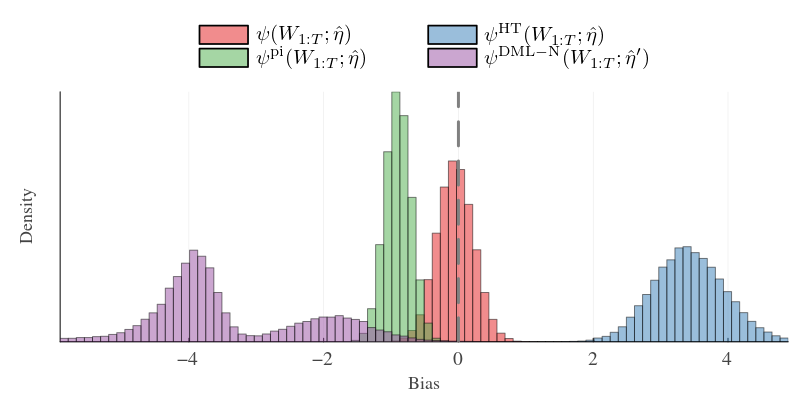

In [144]:

# Create histogram of estimates

psi_star = mean(true_direct_effects)
dml_naive_lower = quantile(dml_naive_estimates, 0.075) - psi_star
dml_naive_upper = quantile(dml_naive_estimates, 0.95) - psi_star
dml_ade_lower = quantile(dml_ade_estimates, pct) - psi_star
dml_ade_upper = quantile(dml_ade_estimates, 1-pct) - psi_star
naive_ade_lower = quantile(naive_ade_estimates, pct) - psi_star
naive_ade_upper = quantile(naive_ade_estimates, 0.995) - psi_star
plugin_ade_lower = quantile(plugin_ade_estimates, pct) - psi_star
plugin_ade_upper = quantile(plugin_ade_estimates, 1-pct) - psi_star

bin_lower = min(dml_ade_lower, naive_ade_lower, plugin_ade_lower, dml_naive_lower)
bin_upper = max(dml_ade_upper, naive_ade_upper, plugin_ade_upper, dml_naive_upper)
incr = (bin_upper - bin_lower) / n_bins
bins = bin_lower:incr:bin_upper

colors_ade = palette(:Set1, 9)


p = plot(legendfontsize=LEGEND_SIZE,
         tickfontsize=TICK_SIZE,
         label=L"\psi(W_{1:T}; \hat \eta)",
         normalize=true,
         legend=:outertop,
         legend_columns=2,
         foreground_color_legend = nothing,
         bins=bins,
         size=sz,
         left_margin=10mm, 
         bottom_margin=margin,
         yticks = ([], []))
plegend = plot(legend=:outertop,
               legend_columns=4,
               legendfontsize=LEGEND_SIZE,
               tickfontsize=TICK_SIZE,
               foreground_color_legend = nothing,
               size=legendsz)

ests_ade = [dml_ade_estimates, naive_ade_estimates, plugin_ade_estimates, dml_naive_estimates]
biases_ade = [est .- psi_star for est in ests_ade]

labels_ade = [L"\psi(W_{1:T}; \hat \eta)", L"\psi^{\mathrm{HT}}(W_{1:T}; \hat \eta)", L"\psi^{\mathrm{pi}}(W_{1:T}; \hat \eta)", L"\psi^{\mathrm{DML-N}}(W_{1:T}; \hat \eta')"]

for i in 1:length(biases_ade)
       histogram!(p, biases_ade[i],
               alpha=opacity,
               label=labels_ade[i],
               normalize=true,
               bins=bins,
               color=colors_ade[i])
       plot!(plegend, sin,
               alpha=opacity,
               label=labels_ade[i],
               normalize=true,
               color=colors_ade[i])
end


vline!(p, [0], 
       linestyle=:dash, 
       color=:grey, 
       label=nothing,
       linewidth=3)




# title!("Distribution of Direct Effect Estimates")
xlabel!("Bias")
ylabel!("Density")
xlims!(bin_lower, bin_upper)


timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
# savefig("direct_effect_$timestamp.svg");
savefig("direct_effect.svg");
plot!(p)

In [ ]:
# Create vectors of sample sizes and coverages
N = 5000
sample_sizes = Int.(round.(exp10.(range(2, 4, length=10))))

dml_avg_bias_n_ade = zeros(length(sample_sizes))
ssac_avg_bias_n_ade = zeros(length(sample_sizes))
naive_avg_bias_n_ade = zeros(length(sample_sizes))
plugin_avg_bias_n_ade = zeros(length(sample_sizes))
dml_naive_avg_bias_n_ade = zeros(length(sample_sizes))

dml_coverages_n_ade = zeros(length(sample_sizes))
ssac_coverages_n_ade = zeros(length(sample_sizes))
naive_coverages_n_ade = zeros(length(sample_sizes))
plugin_coverages_n_ade = zeros(length(sample_sizes))
dml_naive_coverages_n_ade = zeros(length(sample_sizes))

dml_widths_n_ade = zeros(length(sample_sizes))
ssac_widths_n_ade = zeros(length(sample_sizes))
naive_widths_n_ade = zeros(length(sample_sizes))
plugin_widths_n_ade = zeros(length(sample_sizes))
dml_naive_widths_n_ade = zeros(length(sample_sizes))

dml_std_bias_n_ade = zeros(length(sample_sizes))
ssac_std_bias_n_ade = zeros(length(sample_sizes))
naive_std_bias_n_ade = zeros(length(sample_sizes))
plugin_std_bias_n_ade = zeros(length(sample_sizes))
dml_naive_std_bias_n_ade = zeros(length(sample_sizes))

dml_sds_ade = zeros(length(sample_sizes))
ssac_sds_ade = zeros(length(sample_sizes))
naive_sds_ade = zeros(length(sample_sizes))
plugin_sds_ade = zeros(length(sample_sizes))
dml_naive_sds_ade = zeros(length(sample_sizes))

dml_widths_sds_ade = zeros(length(sample_sizes))
ssac_widths_sds_ade = zeros(length(sample_sizes))
naive_widths_sds_ade = zeros(length(sample_sizes))
plugin_widths_sds_ade = zeros(length(sample_sizes))
dml_naive_widths_sds_ade = zeros(length(sample_sizes))

psi_star = mean(true_direct_effects)
alph = 0.05

for (i, t) in enumerate(sample_sizes)
    
    dml_ade_estimates_i, ipw_ade_estimates_i, plugin_ade_estimates_i, true_direct_effects_i, dml_ade_ses_i, ssac_ses_i, dml_naive_estimates_i, ipw_ade_ses_i, plugin_ses_i, dml_naive_ses_i = run_simulations_ade(N, t, m, n_covariates, switch_period, n_trees, max_depth, alpha_val, sd_error, eps)

    dml_avg_bias_n_ade[i] = mean(dml_ade_estimates_i) - psi_star
    ssac_avg_bias_n_ade[i] = mean(ssac_ses_i) - psi_star
    naive_avg_bias_n_ade[i] = mean(ipw_ade_estimates_i) - psi_star
    plugin_avg_bias_n_ade[i] = mean(plugin_ade_estimates_i) - psi_star
    dml_naive_avg_bias_n_ade[i] = mean(dml_naive_estimates_i) - psi_star

    dml_ci_lower, dml_ci_upper = make_gaussian_cis(dml_ade_estimates_i, dml_ade_ses_i, alph)
    ssac_ci_lower, ssac_ci_upper = make_gaussian_cis(dml_ade_estimates_i, ssac_ses_i, alph)
    naive_ci_lower, naive_ci_upper = make_gaussian_cis(ipw_ade_estimates_i, ipw_ade_ses_i, alph)
    plugin_ci_lower, plugin_ci_upper = make_gaussian_cis(plugin_ade_estimates_i, plugin_ses_i, alph)
    dml_naive_ci_lower, dml_naive_ci_upper = make_gaussian_cis(dml_naive_estimates_i, dml_naive_ses_i, alph)
    
    dml_coverages_n_ade[i] = mean((dml_ci_lower .<= psi_star .<= dml_ci_upper))
    ssac_coverages_n_ade[i] = mean((ssac_ci_lower .<= psi_star .<= ssac_ci_upper))
    naive_coverages_n_ade[i] = mean((naive_ci_lower .<= psi_star .<= naive_ci_upper))
    plugin_coverages_n_ade[i] = mean((plugin_ci_lower .<= psi_star .<= plugin_ci_upper))
    dml_naive_coverages_n_ade[i] = mean((dml_naive_ci_lower .<= psi_star .<= dml_naive_ci_upper))

    dml_widths_n_ade[i] = mean(dml_ci_upper - dml_ci_lower)
    ssac_widths_n_ade[i] = mean(ssac_ci_upper - ssac_ci_lower)
    naive_widths_n_ade[i] = mean(naive_ci_upper - naive_ci_lower)
    plugin_widths_n_ade[i] = mean(plugin_ci_upper - plugin_ci_lower)
    dml_naive_widths_n_ade[i] = mean(dml_naive_ci_upper - dml_naive_ci_lower)

    dml_sds_ade[i] = std((dml_ci_lower .<= psi_star .<= dml_ci_upper)) / sqrt(N)
    ssac_sds_ade[i] = std((ssac_ci_lower .<= psi_star .<= ssac_ci_upper)) / sqrt(N)
    naive_sds_ade[i] = std((naive_ci_lower .<= psi_star .<= naive_ci_upper)) / sqrt(N)
    plugin_sds_ade[i] = std((plugin_ci_lower .<= psi_star .<= plugin_ci_upper)) / sqrt(N)
    dml_naive_sds_ade[i] = std((dml_naive_ci_lower .<= psi_star .<= dml_naive_ci_upper)) / sqrt(N)

    dml_widths_sds_ade[i] = std(dml_ci_upper - dml_ci_lower) / sqrt(N)
    ssac_widths_sds_ade[i] = std(ssac_ci_upper - ssac_ci_lower) / sqrt(N)
    naive_widths_sds_ade[i] = std(naive_ci_upper - naive_ci_lower) / sqrt(N)
    plugin_widths_sds_ade[i] = std(plugin_ci_upper - plugin_ci_lower) / sqrt(N)
    dml_naive_widths_sds_ade[i] = std(dml_naive_ci_upper - dml_naive_ci_lower) / sqrt(N)

    dml_std_bias_n_ade[i] = std(dml_ade_estimates_i)
    ssac_std_bias_n_ade[i] = std(ssac_ses_i)
    naive_std_bias_n_ade[i] = std(ipw_ade_estimates_i)
    plugin_std_bias_n_ade[i] = std(plugin_ade_estimates_i)
    dml_naive_std_bias_n_ade[i] = std(dml_naive_estimates_i)
end


Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.8337
R²: 0.6244
Propensity model -- Out of sample:
RMSE: 0.4193
R²: 0.2482
Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.9299
R²: 0.6298
Propensity model -- Out of sample:
RMSE: 0.3728
R²: 0.3962
Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.586
R²: 0.7265
Propensity model -- Out of sample:
RMSE: 0.3674
R²: 0.3838
Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.3073
R²: 0.8267
Propensity model -- Out of sample:
RMSE: 0.3762
R²: 0.3994
Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.236
R²: 0.8473
Propensity model -- Out of sample:
RMSE: 0.3565
R²: 0.4469
Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.0022
R²: 0.8969
Propensity model -- Out of sample:
RMSE: 0.3562
R²: 0.445
Direct effect model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 1.0211
R²

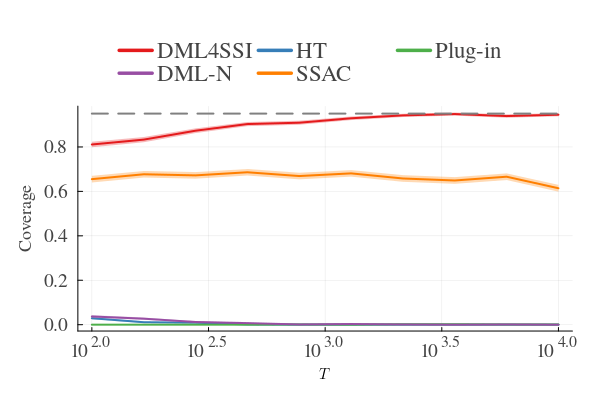

In [119]:
# Compute standard deviations for coverage estimates
margin = 5mm
max_ind = 10 
plot(legend=:outertop,
     legend_columns=3,
     legendfontsize=LEGEND_SIZE,
     tickfontsize=TICK_SIZE,
     xlabel=L"$T$",
     ylabel="Coverage", 
     xscale=:log10,
     margin=margin,
     foreground_color_legend = nothing,
     size=(600, 400))

coverages = [dml_coverages_n_ade, naive_coverages_n_ade, plugin_coverages_n_ade, dml_naive_coverages_n_ade, ssac_coverages_n_ade]
labels = ["DML4SSI", "HT", "Plug-in", "DML-N", "SSAC"]
sds = [dml_sds_ade, naive_sds_ade, plugin_sds_ade, dml_naive_sds_ade, ssac_sds_ade]

for i in 1:length(coverages)
    plot!(sample_sizes[1:max_ind], coverages[i][1:max_ind],
          ribbon=sds[i][1:max_ind],
          fillalpha=0.3,
          label=labels[i], 
          linewidth=2,
          color=colors_ade[i])
end
plot!(sample_sizes[1:max_ind], fill(0.95, length(sample_sizes[1:max_ind])),
      label=nothing,
      linewidth=2,
      linestyle=:dash,
      color=:grey)
      
xticks!(10 .^ [2,2.5,3,3.5,4])

savefig("coverage_vs_sample_size.svg")
plot!()

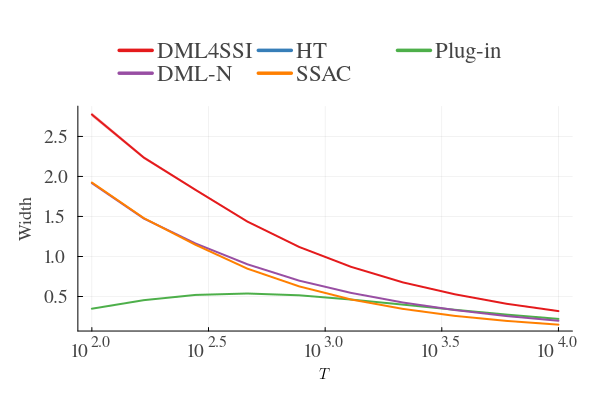

In [120]:

plot(legend=:outertop,
     legend_columns=3,
     legendfontsize=LEGEND_SIZE,
     tickfontsize=TICK_SIZE,
     xlabel=L"$T$",
     ylabel="Width", 
     linewidth=2,
     foreground_color_legend = nothing,
     xscale=:log10,
     margin=margin,
     size=(600, 400))

widths = [dml_widths_n_ade, naive_widths_n_ade, plugin_widths_n_ade, dml_naive_widths_n_ade, ssac_widths_n_ade]
labels = ["DML4SSI", "HT", "Plug-in", "DML-N", "SSAC"]
sds = [dml_widths_sds_ade, ssac_widths_sds_ade, naive_widths_sds_ade, plugin_widths_sds_ade, dml_naive_widths_sds_ade]
for i in 1:length(widths)
    plot!(sample_sizes[1:max_ind], widths[i][1:max_ind],
          ribbon=sds[i][1:max_ind],
          fillalpha=0.3,
          label=labels[i], 
          linewidth=2,
          color=colors_ade[i])
end


xticks!(10 .^ [2,2.5,3,3.5,4])

      
savefig("width_vs_sample_size.svg")
plot!()

In [13]:
function run_simulations_sb(N, T, m, n_covariates, switch_period, n_trees, max_depth, alpha, sd_error, eps = 0.05; beta = 0.5)
    switchback_estimates = zeros(N)
    dml_switchback_estimates = zeros(N)
    naive_sb_estimates = zeros(N)
    true_gte = zeros(N)
    plugin_sb_estimates = zeros(N)
    dml_naive_estimates = zeros(N)
    plugin_naive_estimates = zeros(N)
    ssac_estimates = zeros(N)

    switchback_ses = zeros(N)
    dml_switchback_ses = zeros(N) 
    dml_naive_ses = zeros(N) 
    plugin_ses = zeros(N) 
    ipw_ses = zeros(N) 
    ssac_ses = zeros(N)
    for i in 1:N
        # Train new predictor on auxiliary data for switchback
        switchback_model, switchback_propensity_model = generate_models(T, m, n_covariates, switch_period; mode="switch", est_ade = false, alpha=alpha, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps)

        if i == 1
            println("Switchback model -- Out of sample:")
            evaluate_models(switchback_model, switchback_propensity_model; mode="switch", est_ade=false, alpha=alpha, sd_error=sd_error, eps=eps)
        end
        
        # Switchback experiments
        D, X, H, Y = dgp(T, m, n_covariates, switch_period; mode = "switch", est_ade = false, alpha=alpha, sd_error=sd_error, beta = beta)
        switchback_estimates[i], valid_obs = switchback_ht(D, Y, m)
        dml_switchback_estimates_phi, plugin_sb_estimates_phi = dml4ssi_phi_switchback(D, X, H, Y, switchback_model, m, switch_period)
        ssac_estimates_phi, _ = dml4ssi_phi_ade(D, X, H, Y, switchback_model, switchback_propensity_model, eps)
        dml_switchback_estimates[i] = mean(dml_switchback_estimates_phi)
        plugin_sb_estimates[i] = mean(plugin_sb_estimates_phi)
        naive_sb_estimates[i] = mean(Y[D.==1]) - mean(Y[D.==0])
        ssac_estimates[i] = mean(ssac_estimates_phi)
        naive_outcome_model, naive_propensity_model = generate_naive_models(T, m, n_covariates, switch_period; mode="switch", est_ade=false, alpha=alpha, sd_error=sd_error, n_trees=n_trees, max_depth=max_depth, eps=eps, beta = beta)
        dml_naive_estimates[i] = naive_dml(D, X, Y, naive_outcome_model, naive_propensity_model, eps)

        dml_switchback_ses[i] = sqrt(max(dml4ssi_var(T, dml_switchback_estimates_phi, m, sb=true) / T, 0))
        plugin_ses[i] = sqrt(max(dml4ssi_var(T, plugin_sb_estimates_phi, m, sb=true) / T, 0))
        ipw_ses[i] = sqrt(max(ipw_var(D, X, Y, naive_propensity_model, eps) / T, 0))
        dml_naive_ses[i] = sqrt(max(ssac_var(T, dml_naive_estimates) / T, 0))
        ssac_ses[i] = sqrt(max(ssac_var(T, ssac_estimates_phi) / T, 0))
        # Compute switchback ses from Bojinov et al. (2021)
        num_switches = Int(floor(T / m))
        switchback_ses[i] = 8*mean(Y[m+1:2m])^2 + 8*mean(Y[T-m+1:T])^2
        for j in 1:(num_switches-3)
            switchback_ses[i] += 32*mean(Y[m*(j+1)+1:m*(j+2)] .* valid_obs[m*(j+1)+1:m*(j+2)])^2 
        end
        switchback_ses[i] = sqrt(switchback_ses[i] / (T-m)^2)



        D_global_control, X_global_control, H_global_control, Y_global_control = dgp(T, m, n_covariates, switch_period; mode = "global control", est_ade = false, alpha=alpha, sd_error=sd_error)
        D_global_treatment, X_global_treatment, H_global_treatment, Y_global_treatment= dgp(T, m, n_covariates, switch_period; mode = "global treatment", est_ade = false, alpha=alpha, sd_error=sd_error)
        true_gte[i] = mean(Y_global_treatment) - mean(Y_global_control)

    end
    
    return switchback_estimates, dml_switchback_estimates, naive_sb_estimates, true_gte, plugin_sb_estimates, dml_switchback_ses, dml_naive_estimates, switchback_ses, ipw_ses, plugin_ses, dml_naive_ses, ssac_estimates, ssac_ses
end


run_simulations_sb (generic function with 2 methods)

In [ ]:
N = 50000
T = 1000
m = 5
n_covariates = 1
switch_period = 10
sd_error = 10

n_trees = 100
max_depth = 10
alpha_val = 2
eps = 0.1

switchback_estimates, dml_switchback_estimates, naive_sb_estimates, true_gte, plugin_sb_estimates, dml_switchback_ses, dml_naive_estimates_sb, switchback_ses, ipw_ses, plugin_ses, dml_naive_ses, ssac_estimates, ssac_ses = run_simulations_sb(N, T, m, n_covariates, switch_period, n_trees, max_depth, alpha_val, sd_error, eps)

Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.3045
R²: 0.927
Propensity model -- Out of sample:
RMSE: 0.553
R²: -0.2355


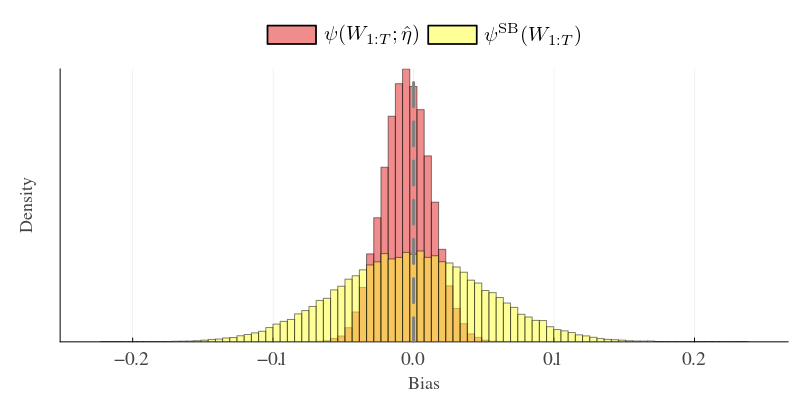

In [135]:
# Create histogram of estimates
colors_sb = colors_ade
psi_star_sb = mean(true_gte)
switchback_lower = minimum(switchback_estimates)-psi_star_sb
switchback_upper = maximum(switchback_estimates)-psi_star_sb
dml_switchback_lower = minimum(dml_switchback_estimates)-psi_star_sb
dml_switchback_upper = maximum(dml_switchback_estimates)-psi_star_sb
bin_lower = min(switchback_lower, dml_switchback_lower)
bin_upper = max(switchback_upper, dml_switchback_upper)
incr = (bin_upper - bin_lower) / n_bins
bins = bin_lower:incr:bin_upper

histogram(dml_switchback_estimates .- psi_star_sb, 
          alpha=opacity, 
          label=L"\psi(W_{1:T}; \hat \eta)",
          normalize=true,
          bins=bins,
          legendfontsize=LEGEND_SIZE,
          tickfontsize=TICK_SIZE,
          legend=:outertop,
          legend_columns=2,
          foreground_color_legend = nothing,
          color=colors_sb[1],
          size=sz,
          left_margin=10mm, 
          bottom_margin=margin,
          yticks=([], []),
          legend_markerstrokecolor = :transparent)
histogram!(switchback_estimates .- psi_star_sb, 
         alpha=0.5,
         label=L"\psi^{\mathrm{SB}}(W_{1:T})", 
         normalize=true,
         bins=bins,
         legendfontsize=LEGEND_SIZE,
         tickfontsize=TICK_SIZE,
         color=colors_sb[6])
vline!([0], 
       linestyle=:dash, 
       color=:grey, 
       label=nothing,
       linewidth=3)
xlabel!("Bias")
ylabel!("Density")

timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
# savefig("switchback_$timestamp.svg");
savefig("switchback.svg");
plot!()

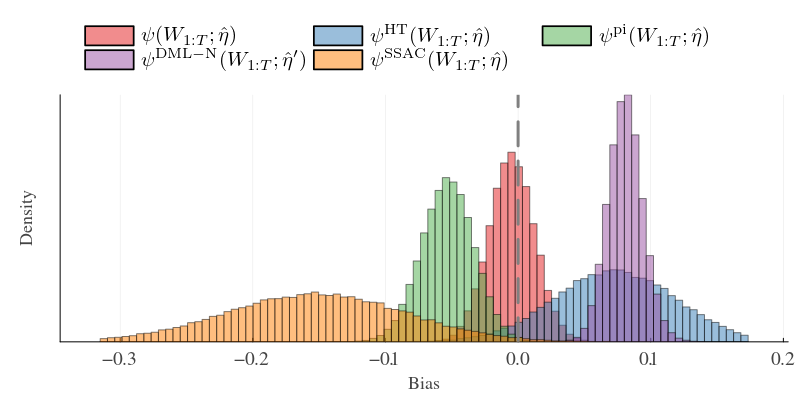

In [134]:
# Create histogram of estimates
pct = 0.01
psi_star_sb = mean(true_gte)
naive_sb_lower = quantile(naive_sb_estimates, pct) - psi_star_sb
naive_sb_upper = quantile(naive_sb_estimates, 1-pct) - psi_star_sb
plugin_sb_lower = quantile(plugin_sb_estimates, pct) - psi_star_sb
plugin_sb_upper = quantile(plugin_sb_estimates, 1-pct) - psi_star_sb
dml_sb_lower = quantile(dml_switchback_estimates, pct) - psi_star_sb
dml_sb_upper = quantile(dml_switchback_estimates, 1-pct) - psi_star_sb
ssac_lower = quantile(ssac_estimates, pct) - psi_star_sb
ssac_upper = quantile(ssac_estimates, 1-pct) - psi_star_sb
# dml_naive_lower = quantile(dml_naive_estimates_sb, 0.3) - psi_star
# dml_naive_upper = quantile(dml_naive_estimates_sb, 1-0.3) - psi_star
bin_lower = min(naive_sb_lower,plugin_sb_lower,dml_sb_lower,ssac_lower)
bin_upper = max(naive_sb_upper,plugin_sb_upper,dml_sb_upper,ssac_upper)
incr = (bin_upper - bin_lower) / n_bins
bins = bin_lower:incr:bin_upper

plot(legendfontsize=LEGEND_SIZE,
       tickfontsize=TICK_SIZE,
       legend=:outertop,
       foreground_color_legend = nothing,
       legend_columns=3,
       size=sz,
       left_margin=10mm, 
       bottom_margin=margin,
       yticks=([], []), legend_markerstrokecolor=:transparent)

ests_sb = [dml_switchback_estimates, naive_sb_estimates, plugin_sb_estimates, dml_naive_estimates_sb, ssac_estimates]
biases_sb = [ests_sb[i] .- psi_star_sb for i in 1:length(ests_sb)]
labels_sb = [L"\psi(W_{1:T}; \hat \eta)", L"\psi^{\mathrm{HT}}(W_{1:T}; \hat \eta)", L"\psi^{\mathrm{pi}}(W_{1:T}; \hat \eta)", L"\psi^{\mathrm{DML-N}}(W_{1:T}; \eta')", L"\psi^{\mathrm{SSAC}}(W_{1:T}; \hat \eta)"]

for i in 1:length(biases_sb)
    histogram!(biases_sb[i],
               color=colors_sb[i],
               alpha=opacity,
               label=labels_sb[i],
               normalize=true,
               bins=bins)
end

vline!([0], 
       linestyle=:dash, 
       color=:grey, 
       label=nothing,
       linewidth=3)

xlabel!("Bias")
ylabel!("Density")

timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
# savefig("switchback_vs_naive_$timestamp.svg");
savefig("switchback_vs_naive.svg");
plot!()

In [172]:
N = 5000
T = 1000
m = 5
n_covariates = 1
switch_period = 10
sd_error = 10

alpha_val = 2
eps = 0.1

n_trees = 100
max_depth = 10


sample_sizes = Int.(round.(exp10.(range(2, 4, length=10))))

dml_avg_bias_n_sb = zeros(length(sample_sizes))
naive_avg_bias_n_sb = zeros(length(sample_sizes))
plugin_avg_bias_n_sb = zeros(length(sample_sizes))
dml_naive_avg_bias_n_sb = zeros(length(sample_sizes))
switchback_avg_bias_n_sb = zeros(length(sample_sizes))
ssac_avg_bias_n_sb = zeros(length(sample_sizes))

dml_coverages_n_sb = zeros(length(sample_sizes))
naive_coverages_n_sb = zeros(length(sample_sizes))
plugin_coverages_n_sb = zeros(length(sample_sizes))
dml_naive_coverages_n_sb = zeros(length(sample_sizes))
switchback_coverages_n_sb = zeros(length(sample_sizes))
ssac_coverages_n_sb = zeros(length(sample_sizes))

dml_widths_n_sb = zeros(length(sample_sizes))
naive_widths_n_sb = zeros(length(sample_sizes))
plugin_widths_n_sb = zeros(length(sample_sizes))
dml_naive_widths_n_sb = zeros(length(sample_sizes))
switchback_widths_n_sb = zeros(length(sample_sizes))
ssac_widths_n_sb = zeros(length(sample_sizes))

dml_std_bias_n_sb = zeros(length(sample_sizes))
naive_std_bias_n_sb = zeros(length(sample_sizes))
plugin_std_bias_n_sb = zeros(length(sample_sizes))
dml_naive_std_bias_n_sb = zeros(length(sample_sizes))
switchback_std_bias_n_sb = zeros(length(sample_sizes))
ssac_std_bias_n_sb = zeros(length(sample_sizes))

dml_sds_n_sb = zeros(length(sample_sizes))
naive_sds_n_sb = zeros(length(sample_sizes))
plugin_sds_n_sb = zeros(length(sample_sizes))
dml_naive_sds_n_sb = zeros(length(sample_sizes))
switchback_sds_n_sb = zeros(length(sample_sizes))
ssac_sds_n_sb = zeros(length(sample_sizes))

dml_width_sds_n_sb = zeros(length(sample_sizes))
naive_width_sds_n_sb = zeros(length(sample_sizes))
plugin_width_sds_n_sb = zeros(length(sample_sizes))
dml_naive_width_sds_n_sb = zeros(length(sample_sizes))
switchback_width_sds_n_sb = zeros(length(sample_sizes))
ssac_width_sds_n_sb = zeros(length(sample_sizes))

psi_star_sb = mean(true_gte)
alph = 0.05

for (i, t) in enumerate(sample_sizes)
    
    switchback_estimates_i, dml_switchback_estimates_i, naive_sb_estimates_i, true_gte_i, plugin_sb_estimates_i, dml_switchback_ses_i, dml_naive_estimates_sb_i, switchback_ses_i, ipw_ses_i, plugin_ses_i, dml_naive_ses_i, ssac_estimates_i, ssac_ses_i = run_simulations_sb(N, t, m, n_covariates, switch_period, n_trees, max_depth, alpha_val, sd_error, eps)
    
    dml_avg_bias_n_sb[i] = mean(dml_switchback_estimates_i) - psi_star_sb
    naive_avg_bias_n_sb[i] = mean(filter(!isnan, naive_sb_estimates_i)) - psi_star_sb
    plugin_avg_bias_n_sb[i] = mean(plugin_sb_estimates_i) - psi_star_sb
    dml_naive_avg_bias_n_sb[i] = mean(dml_naive_estimates_sb_i) - psi_star_sb
    switchback_avg_bias_n_sb[i] = mean(switchback_estimates_i) - psi_star_sb
    ssac_avg_bias_n_sb[i] = mean(ssac_estimates_i) - psi_star_sb

    
    dml_ci_lower, dml_ci_upper = make_gaussian_cis(dml_switchback_estimates_i, dml_switchback_ses_i, alph)
    naive_ci_lower, naive_ci_upper = make_gaussian_cis(naive_sb_estimates_i, ipw_ses_i, alph)
    plugin_ci_lower, plugin_ci_upper = make_gaussian_cis(plugin_sb_estimates_i, plugin_ses_i, alph)
    dml_naive_ci_lower, dml_naive_ci_upper = make_gaussian_cis(dml_naive_estimates_sb_i, dml_naive_ses_i, alph)
    switchback_ci_lower, switchback_ci_upper = make_gaussian_cis(switchback_estimates_i, switchback_ses_i, alph)
    sb_ssac_ci_lower, sb_ssac_ci_upper = make_gaussian_cis(ssac_estimates_i, ssac_ses_i, alph)

    dml_coverages_n_sb[i] = mean((dml_ci_lower .<= psi_star_sb .<= dml_ci_upper))
    switchback_coverages_n_sb[i] = mean((switchback_ci_lower .<= psi_star_sb .<= switchback_ci_upper))
    naive_coverages_n_sb[i] = mean((naive_ci_lower .<= psi_star_sb .<= naive_ci_upper))
    plugin_coverages_n_sb[i] = mean((plugin_ci_lower .<= psi_star_sb .<= plugin_ci_upper))
    dml_naive_coverages_n_sb[i] = mean((dml_naive_ci_lower .<= psi_star_sb .<= dml_naive_ci_upper))
    ssac_coverages_n_sb[i] = mean((sb_ssac_ci_lower .<= psi_star_sb .<= sb_ssac_ci_upper))

    dml_widths_n_sb[i] = mean(dml_ci_upper - dml_ci_lower)
    naive_widths_n_sb[i] = mean(filter(!isnan, naive_ci_upper - naive_ci_lower))
    plugin_widths_n_sb[i] = mean(plugin_ci_upper - plugin_ci_lower)
    dml_naive_widths_n_sb[i] = mean(dml_naive_ci_upper - dml_naive_ci_lower)
    switchback_widths_n_sb[i] = mean(switchback_ci_upper - switchback_ci_lower)
    ssac_widths_n_sb[i] = mean(sb_ssac_ci_upper - sb_ssac_ci_lower)

    dml_std_bias_n_sb[i] = std(dml_switchback_estimates_i)
    naive_std_bias_n_sb[i] = std(naive_sb_estimates_i)
    plugin_std_bias_n_sb[i] = std(plugin_sb_estimates_i)
    dml_naive_std_bias_n_sb[i] = std(dml_naive_estimates_sb_i)
    switchback_std_bias_n_sb[i] = std(switchback_estimates_i)
    ssac_std_bias_n_sb[i] = std(ssac_estimates_i)

    dml_sds_n_sb[i] = std((dml_ci_lower .<= psi_star_sb .<= dml_ci_upper)) / sqrt(N)
    naive_sds_n_sb[i] = std((naive_ci_lower .<= psi_star_sb .<= naive_ci_upper)) / sqrt(N)
    plugin_sds_n_sb[i] = std((plugin_ci_lower .<= psi_star_sb .<= plugin_ci_upper)) / sqrt(N)
    dml_naive_sds_n_sb[i] = std((dml_naive_ci_lower .<= psi_star_sb .<= dml_naive_ci_upper)) / sqrt(N)
    switchback_sds_n_sb[i] = std((switchback_ci_lower .<= psi_star_sb .<= switchback_ci_upper)) / sqrt(N)
    ssac_sds_n_sb[i] = std((sb_ssac_ci_lower .<= psi_star_sb .<= sb_ssac_ci_upper)) / sqrt(N)

    dml_width_sds_n_sb[i] = std(dml_ci_upper - dml_ci_lower) / sqrt(N)
    naive_width_sds_n_sb[i] = std(filter(!isnan, naive_ci_upper - naive_ci_lower)) / sqrt(N)
    plugin_width_sds_n_sb[i] = std(plugin_ci_upper - plugin_ci_lower) / sqrt(N)
    dml_naive_width_sds_n_sb[i] = std(dml_naive_ci_upper - dml_naive_ci_lower) / sqrt(N)
    switchback_width_sds_n_sb[i] = std(switchback_ci_upper - switchback_ci_lower) / sqrt(N)
    ssac_width_sds_n_sb[i] = std(sb_ssac_ci_upper - sb_ssac_ci_lower) / sqrt(N)


end


Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.5555
R²: 0.7618
Propensity model -- Out of sample:
RMSE: 0.5355
R²: -0.1545
Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.5285
R²: 0.7937
Propensity model -- Out of sample:
RMSE: 0.6083
R²: -0.4852
Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.4486
R²: 0.8405
Propensity model -- Out of sample:
RMSE: 0.53
R²: -0.1351
Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.3996
R²: 0.8804
Propensity model -- Out of sample:
RMSE: 0.558
R²: -0.2458
Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.2875
R²: 0.9345
Propensity model -- Out of sample:
RMSE: 0.5377
R²: -0.157
Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.2915
R²: 0.9334
Propensity model -- Out of sample:
RMSE: 0.5468
R²: -0.2134
Switchback model -- Out of sample:
Outcome model -- Out of sample:
RMSE: 0.2354
R²: 0.958
Propensi

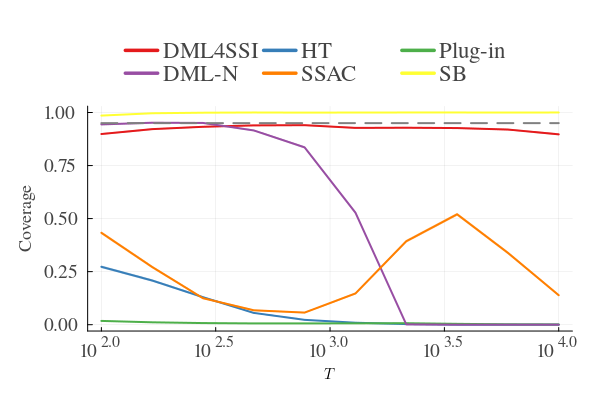

In [173]:

plot(legend=:outertop,
     legend_columns=3,
     legendfontsize=LEGEND_SIZE,
     tickfontsize=TICK_SIZE,
     xlabel=L"$T$",
     ylabel="Coverage", 
     foreground_color_legend = nothing,
     xscale=:log10,
     margin=margin,
     size=(600, 400))

sb_coverages = [dml_coverages_n_sb, naive_coverages_n_sb, plugin_coverages_n_sb, dml_naive_coverages_n_sb, ssac_coverages_n_sb, switchback_coverages_n_sb]
sb_sds = [dml_sds_n_sb, naive_sds_n_sb, plugin_sds_n_sb, dml_naive_sds_n_sb, ssac_sds_n_sb, switchback_sds_n_sb]
labels = ["DML4SSI", "HT", "Plug-in", "DML-N", "SSAC", "SB"]

for i in 1:length(sb_coverages)
    plot!(sample_sizes, sb_coverages[i],
          ribbon=sb_sds[i],
          fillalpha=0.3,
          label=labels[i],
          linewidth=2,
          color=colors_sb[i])
end

plot!(sample_sizes, fill(0.95, length(sample_sizes)),
      label=nothing,
      linewidth=2,
      linestyle=:dash,
      color=:grey)

xticks!(10 .^ [2,2.5,3,3.5,4])

      
savefig("sb_coverage_vs_sample_size.svg")
plot!()

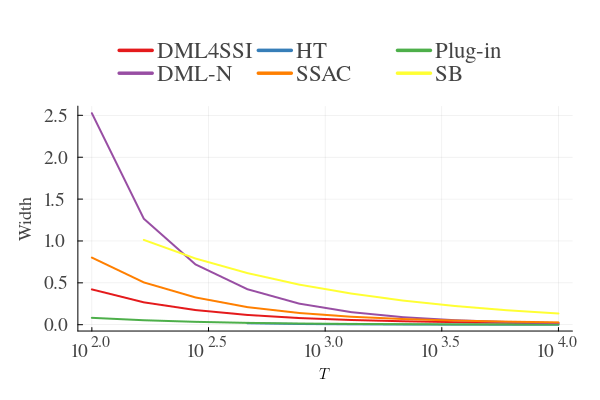

In [174]:

plot(legend=:outertop,
     legend_columns=3,
     legendfontsize=LEGEND_SIZE,
     tickfontsize=TICK_SIZE,
     xlabel=L"$T$",
     ylabel="Width", 
     foreground_color_legend = nothing,
     xscale=:log10,
     margin=margin,
     size=(600, 400))

sb_widths = [dml_widths_n_sb, naive_widths_n_sb, plugin_widths_n_sb, dml_naive_widths_n_sb, ssac_widths_n_sb, switchback_widths_n_sb]
sb_width_sds = [dml_width_sds_n_sb, naive_width_sds_n_sb, plugin_width_sds_n_sb, dml_naive_width_sds_n_sb, ssac_width_sds_n_sb, switchback_width_sds_n_sb]
labels = ["DML4SSI", "HT", "Plug-in", "DML-N", "SSAC", "SB"]

for i in 1:length(sb_widths)
    plot!(sample_sizes, sb_widths[i],
          ribbon=sb_width_sds[i],
          fillalpha=0.3,
          label=labels[i],
          linewidth=2,
          color=colors_sb[i])
end



xticks!(10 .^ [2,2.5,3,3.5,4])

      
savefig("sb_width_vs_sample_size.svg")
plot!()